## Kaggle Competition: Personalized Medicine - Redefining Cancer Treatment
### _Predict the effect of Genetic Variants to enable Personalized Medicine_
#### Competition website: https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview
#### Competition description (from website):
##### Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC (Memorial Sloan Kettering Cancer Center) is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.
#### Competition evaluation (from website):
##### Submissions are evaluated on MULTI-CLASS LOG LOSS between the predicted probability (of 9 different classes of genetic variations) and the observed target.
#### Models' public test-set evaluation:
##### Recall rate (multi-class weighted avg.), per standard medical statistical metrics. Recall formula: tp/(tp+fn).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.classification import log_loss

from IPython.display import Markdown as md

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print(tf.__version__)

C:\Users\dcunz\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


2.1.0


In [2]:
# setup and check for tensorflow access to CPU/GPU resources
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8095769243008158335
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4828102656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9395030180808440325
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# read in full training data
training_variants=pd.read_csv('training_variants')
training_text=pd.read_csv('training_text',sep='\|\|',engine='python',skiprows=1,names=['ID','Text'])

In [4]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
training_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
sample_submission=pd.read_csv('stage2_sample_submission.csv')

In [7]:
sample_submission.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0


In [8]:
classes=sample_submission.shape[1]-1
print(classes)

9


### Create random classification probabilities to establish baseline max. MULTICLASS LOG-LOSS metric

In [9]:
#test code for creating array of probabilities that add up to 1.0
a=np.random.rand(9)
print(a)
print(a.sum())
a=a/a.sum()
print(a)
b=a.sum()
print(b)
if b>1.0:
    a[0]=a[0]-(b-1.0) #correct for numerical error in sum
print(a.sum())

[0.82887037 0.55054247 0.13597265 0.8751015  0.12468699 0.7349898
 0.14392034 0.56654376 0.14812853]
4.108756414791285
[0.20173266 0.13399248 0.03309338 0.21298452 0.03034665 0.17888376
 0.03502771 0.13788692 0.03605191]
1.0
1.0


In [10]:
random_classification_probabilities=np.zeros((training_variants.shape[0],classes))
random_classification_probabilities.shape

(3321, 9)

In [11]:
for i in range(random_classification_probabilities.shape[0]):
    a=np.random.rand(classes)
    a=a/a.sum()
    b=a.sum()
    if b>1.0:
        a[0]=a[0]-(b-1.0) #correct for numerical error in sum
    random_classification_probabilities[i]=a
random_classification_probabilities.shape

(3321, 9)

In [12]:
random_classification_probabilities[:5,:]

array([[0.01243347, 0.19548559, 0.0568395 , 0.05804933, 0.05203745,
        0.26321927, 0.22396116, 0.12799843, 0.00997581],
       [0.10506636, 0.17613128, 0.0290379 , 0.17258963, 0.15490925,
        0.10102236, 0.09848294, 0.1018825 , 0.06087778],
       [0.10435634, 0.13604905, 0.02340455, 0.09642764, 0.18957841,
        0.1674571 , 0.07039953, 0.20424651, 0.00808087],
       [0.14735177, 0.14310519, 0.05020079, 0.09891393, 0.13941441,
        0.07184641, 0.10559425, 0.05857719, 0.18499607],
       [0.08453184, 0.08432344, 0.09921862, 0.09989717, 0.16039868,
        0.15546076, 0.06451697, 0.14867312, 0.10297939]])

In [13]:
y_true=training_variants.Class.values #convert Series to array
y_true

array([1, 2, 2, ..., 1, 4, 4], dtype=int64)

In [14]:
random_multiclass_log_loss=log_loss(y_true,random_classification_probabilities,labels=[1,2,3,4,5,6,7,8,9])

In [15]:
md(">Baseline worst-case (random) multi-class log-loss: {}".format(round(random_multiclass_log_loss,6)))

>Baseline worst-case (random) multi-class log-loss: 2.496368

In [16]:
#merge both training dataframes
training_full=training_variants.merge(training_text, on='ID', how='inner')

In [17]:
training_full.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [18]:
training_full.tail()

,ID,Gene,Variation,Class,Text
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,RUNX1,K83E,4,The most frequent mutations associated with le...


In [19]:
training_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [20]:
#review missing values for 'Text'
indices_of_missing_Text=training_full[training_full['Text'].isnull()==True].index
training_full.iloc[indices_of_missing_Text]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [21]:
#remove leading and trailing spaces and lower-case 'Gene' and 'Variation' features
training_full['Gene']=training_full['Gene'].apply(lambda x: x.strip())
training_full['Gene']=training_full['Gene'].apply(lambda x: x.lower())
training_full['Variation']=training_full['Variation'].apply(lambda x: x.strip())
training_full['Variation']=training_full['Variation'].apply(lambda x: x.lower())

In [22]:
#impute missing value for 'Text', by combining its corresponding 'Gene', 'Variation' features (separated by one white space)
training_full.Text.fillna((training_full.Gene+' '+training_full.Variation),inplace=True)
training_full.iloc[indices_of_missing_Text]

,ID,Gene,Variation,Class,Text
1109,1109,fanca,s1088f,1,fanca s1088f
1277,1277,arid5b,truncating mutations,1,arid5b truncating mutations
1407,1407,fgfr3,k508m,6,fgfr3 k508m
1639,1639,flt1,amplification,6,flt1 amplification
2755,2755,braf,g596c,7,braf g596c


In [23]:
pd.value_counts(training_full.Gene)

brca1     264
tp53      163
egfr      141
pten      126
brca2     125
         ... 
arid5b      1
cebpa       1
rad51b      1
kdm5a       1
rybp        1
Name: Gene, Length: 264, dtype: int64

In [24]:
pd.value_counts(training_full.Variation)

truncating mutations    93
deletion                74
amplification           71
fusions                 34
overexpression           6
                        ..
v1804d                   1
l265p                    1
g118d                    1
r812a                    1
m1652t                   1
Name: Variation, Length: 2996, dtype: int64

In [25]:
pd.value_counts(training_full.Class)

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

Text(0.5, 1.0, 'Class counts in full training data')

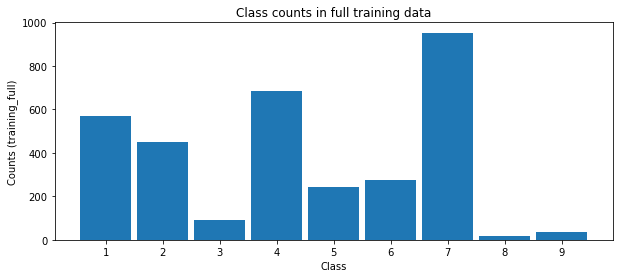

In [26]:
plt.figure(figsize=(10,4))
unique_classes, classes_array = np.unique(training_full['Class'],return_inverse=True)
counts = np.bincount(classes_array)
plt.bar(unique_classes,counts,width=0.9)
plt.xticks(unique_classes)
plt.xlabel('Class')
plt.ylabel('Counts (training_full)')
plt.title('Class counts in full training data')

#### Comment: This shows an IMBALANCED training set, which we may attempt to address via 'over-sampling' technique - 'under-sampling' is not an option in this case, since the training dataset is too small (<~10K).

In [27]:
# upon inspection, 'Variation' and 'Text' features will be cleaned-up in a similar way

In [28]:
# text preprocessor cleanup code, prior to applying the tensorflow Tokenizer

def text_preprocessor_tokenizer(text):
    # remove leading & trailing white spaces
    text=text.strip()
    
    # remove all HTML markup
    text = re.sub('<[^>]*>', '', text)
    
    # find and store emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

    # remove non-word characters
    # convert text to lower-case
    # also want to replace '_' with ' ', per inspections of 'Variation' & 'Text' features
    # add back emoticons at the end of string, remove "nose"='-' of emoticons
    text = re.sub('[\W]+', ' ', text.lower()).replace('_',' ') + ' '.join(emoticons).replace('-', '')
    
    # correction for if emoticon is first/last term
    text = text.strip()
    
    return text

In [29]:
# test text_preprocessor_tokenizer function
text_preprocessor_tokenizer(" ;) </a>This ;) is :( a test :-)! 123 XyZ AbC123* dEf4-5GhI6 789_JkL0 ;) ")
#text_preprocessor_tokenizer(" </a>This is a test! 123 XyZ AbC123* dEf4-5GhI6 789_JkL0 ")

'this is a test 123 xyz abc123 def4 5ghi6 789 jkl0 ;) ;) :( :) ;)'

In [30]:
# clean up text data on BOTH 'Variation' and 'Text' features, prior to applying the tensorflow Tokenizer
training_full['Variation'] = training_full['Variation'].apply(text_preprocessor_tokenizer)
training_full['Text'] = training_full['Text'].apply(text_preprocessor_tokenizer)

In [31]:
training_full.head()

,ID,Gene,Variation,Class,Text
0,0,fam58a,truncating mutations,1,cyclin dependent kinases cdks regulate a varie...
1,1,cbl,w802,2,abstract background non small cell lung cancer...
2,2,cbl,q249e,2,abstract background non small cell lung cancer...
3,3,cbl,n454d,3,recent evidence has demonstrated that acquired...
4,4,cbl,l399v,4,oncogenic mutations in the monomeric casitas b...


In [32]:
training_full.tail()

,ID,Gene,Variation,Class,Text
3316,3316,runx1,d171n,4,introduction myelodysplastic syndromes mds are...
3317,3317,runx1,a122,1,introduction myelodysplastic syndromes mds are...
3318,3318,runx1,fusions,1,the runt related transcription factor 1 gene r...
3319,3319,runx1,r80c,4,the runx1 aml1 gene is the most frequent targe...
3320,3320,runx1,k83e,4,the most frequent mutations associated with le...


### Pre-process 'Text' by removing "STOPWORDS", prior to using the Tensorflow/Keras Tokenizer:

In [33]:
STOPWORDS = set(stopwords.words('english'))
print(len(STOPWORDS))

179


In [34]:
dummy=[]
training_full_Text_list=[]

for i in range(len(training_full)):
    for word in training_full.Text[i].split():
        if word not in list(STOPWORDS):
            dummy.append(word)
    training_full_Text_list.append(dummy)
    dummy=[]

In [35]:
training_full_Text_str=[]
for i in range(len(training_full)):
    training_full_Text_str.append(' '.join(training_full_Text_list[i]))

In [36]:
print(len(training_full_Text_str))
print(type(training_full_Text_str))
print(type(training_full_Text_str[0]))

3321
<class 'list'>
<class 'str'>


In [37]:
# now each training_full_Text_str[x] contains a single string, representing each of the studies, with all STOPWORDS removed
training_full_Text_str[3320]

'frequent mutations associated leukemia recurrent somatic chromosomal translocations inversions many involve polyomavirus enhancer binding protein core binding factor transcriptional regulation complex pebp2 cbf several translocations involve î subunit complex runx1 gene also called aml1 cbfî 2 pebp2î b chromosome 21q22 1 8 21 3 21 12 21 additionally î² subunit complex pebp2î² also called cbfî² disrupted inv 16 p13 q22 1 abundance evidence points existence genes predispose hematologic malignancies however large multiple generation families hematologic malignancies alone rare 2 2 loci familial hematologic malignancies identified date 1 chromosome 21q22 13 16q22 4 5 loci contain runx1 andpebp2î² cbfî² respectively studies families demonstrate single gene inheritance leukemia predisposition help identify genes mechanisms involved first steps leukemia development autosomal dominant familial platelet disorder fpd aml acute myelogenous leukemia online mendelian inheritance man 601399 good mo

#### Re-create full training dataframe by replacing 'Text' with the newly-processed text strings as above:

In [38]:
Text_preprocessed=pd.DataFrame(training_full_Text_str,columns=['Text_preprocessed'])
training_full_df=pd.concat([training_full,Text_preprocessed],axis=1).drop(columns=['Text'])

In [39]:
training_full_df

,ID,Gene,Variation,Class,Text_preprocessed
0,0,fam58a,truncating mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,cbl,w802,2,abstract background non small cell lung cancer...
2,2,cbl,q249e,2,abstract background non small cell lung cancer...
3,3,cbl,n454d,3,recent evidence demonstrated acquired uniparen...
4,4,cbl,l399v,4,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316,runx1,d171n,4,introduction myelodysplastic syndromes mds het...
3317,3317,runx1,a122,1,introduction myelodysplastic syndromes mds het...
3318,3318,runx1,fusions,1,runt related transcription factor 1 gene runx1...
3319,3319,runx1,r80c,4,runx1 aml1 gene frequent target chromosomal tr...


In [40]:
# perform the main train-test splits

# create X,y, not including 'Variation','Text'
y=training_full_df.Class
X=training_full_df.drop(columns=['Class'])

training_ratio = 0.8
test_ratio = 1.0 - training_ratio

# 80%/20% train-test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_ratio,random_state=42,stratify=y)

#reset indices starting from 0, since 'ID' column no longer matches index
X_train_df=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
X_test_df=X_test.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

print('X_train_df shape: {0}'.format(X_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

print('X_test_df shape: {0}'.format(X_test.shape))
print('y_test shape: {0}'.format(y_test.shape))

X_train_df shape: (2656, 4)
y_train shape: (2656,)
X_test_df shape: (665, 4)
y_test shape: (665,)


In [41]:
print(y_train.head())
X_train_df.head()

0    4
1    4
2    4
3    7
4    4
Name: Class, dtype: int64


,ID,Gene,Variation,Text_preprocessed
0,2570,brca1,d1739g,abstract germline mutations inactivate tumor s...
1,2448,brca1,t37r,published analyses effects missense mutations ...
2,1262,pik3r1,k459 s460delinsn,abstract cancer specific mutations ish2 inter ...
3,3168,raf1,amplification,studies comparative genomic hybridization reve...
4,3087,notch1,r1594q,since notch phenotypes drosophila melanogaster...


In [42]:
print(y_test.head())
X_test_df.head()

0    2
1    6
2    7
3    7
4    7
Name: Class, dtype: int64


,ID,Gene,Variation,Text_preprocessed
0,3219,ntrk1,bcan ntrk1 fusion,abstract glioblastoma multiforme gbm aggressiv...
1,2672,brca1,k45t,germline mutations breast cancer 1 brca1 gene ...
2,1706,whsc1,e1099k,acute lymphoblastic leukemia neoplasm lymphocy...
3,3126,kras,y64a,growth factor receptors activate ras recruitin...
4,1677,flt3,e612 f613insgyvdfreyeydlkwefrprenlef,internal tandem duplication itd flt3 gene foun...


### Tokenize Text_preprocessed via Tensorflow/Keras Tokenizer

In [43]:
vocab_size = 10000 #the most common words in corpus
embedding_dim = 128
max_length_seq = 400
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' #special value when unseen word is encountered, that is, a word that is not on word_index

In [44]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_full_df.Text_preprocessed)
word_index = tokenizer.word_index
print(dict(list(word_index.items())[0:10]))
print(dict(list(word_index.items())[-10:-1]))

{'<OOV>': 1, 'mutations': 2, 'cells': 3, '1': 4, '2': 5, 'cell': 6, '3': 7, 'et': 8, 'al': 9, 'mutation': 10}
{'studies8': 145397, 'mgt16': 145398, 'myeloidâ': 145399, 'nervyâ': 145400, 'œsquelchâ': 145401, 'pansorb': 145402, 'sw50': 145403, 'duel': 145404, 'pah2': 145405}


In [45]:
X_train_Text_preprocessed_sequences = tokenizer.texts_to_sequences(X_train_df.Text_preprocessed)

In [46]:
X_train_Text_preprocessed_sequences_padded=pad_sequences(X_train_Text_preprocessed_sequences, maxlen=max_length_seq, padding=padding_type, truncating=trunc_type)

print(len(X_train_Text_preprocessed_sequences[0]))
print(len(X_train_Text_preprocessed_sequences_padded[0]))
print(X_train_Text_preprocessed_sequences_padded[0])

6704
400
[3533  346    2 2846   29  396   32   37   57  126  334  161  139  689
   68 1889  315  108   30   64   56  565 1775  158 1470  269 1029 3211
   14 4440  108    2    1 1390  118  191  907  384 3124   78  119  205
 9260  406 4973 2125 4572   66 1498  907  555   78 1878  408  108    2
 2033   11  160 9044   88  145   77   37  181   50  162  406  817   31
 3124   78 2672  883  278   78  480 1971    2 1152  293  826   81  131
  293  826   48   78 1017 1155 1629  123  253 1589  142  247  109 1268
 1103   91 1611  154  406   78  958  364    1  247  278 3428 5779   37
  108   30  685  641    5  246   16  139   14   96 3395  346    2   37
   32    4    5   28  775  126  334  481  604   14    7   22   37 5768
   29  396   32   38   24  282    1 1754   46  346   10 1030   16   45
   28  389   38   24   37   56   29    6   72   48   63  169    6  366
 1003   51   60  154  346   37    2  493  266   32  744  711  720   37
   91   30    1  139   14  355  494 2174    1 1402 1185    2  454 26

In [47]:
X_test_Text_preprocessed_sequences = tokenizer.texts_to_sequences(X_test_df.Text_preprocessed)

In [48]:
X_test_Text_preprocessed_sequences_padded=pad_sequences(X_test_Text_preprocessed_sequences, maxlen=max_length_seq, padding=padding_type, truncating=trunc_type)

print(len(X_test_Text_preprocessed_sequences[0]))
print(len(X_test_Text_preprocessed_sequences_padded[0]))
print(X_test_Text_preprocessed_sequences_padded[0])

2533
400
[3533 1980 7336 1604 1879  311 1027   29  883  466  341 1910  216 1375
  475   79 1250   46  101  172   61 1039 1020 1060 1174 2826  618 8232
 4054 6508  273  172   61 3469 1699  292 1864   33 7148 1604   21  277
   14  518 3487 1300   64  267  146  352 9900  156   25  105   24    4
 2351  569 2613 1813  246  146  352   61  317  162 4705  689    1    1
    1    1  690 6370 1575   25  149 2351  736 2351 3582 1345  216   70
 6007   63  221 5181  148  743   64 1206  677   56   14 3469 1772 3167
 2351   20  172  204 3469  162  172 1283  106 2840  101  922 2351  112
   18 2819 1160    1 2351  172   32  457  809    3  126  168  142  907
  258 1496 1458   29  258  133  286  721  172 3930 1551 2476  172  204
 3469  200   44 5111  302  219  426  685 1980 7336 1604  265 1879  311
 1027   29 1084  723  184  144    1   19 2875 3358 5196    1    1   19
 1061 2805    1  154  405 1298  216  482 1604   21 7421    4 1598 6577
  219   90  148  185 1605 3469   54  209 1063 6715 3446    4  200   

In [49]:
# visualize an original (pre-processed) article, and the article after tokenization & padding

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [50]:
print(X_train_df.Text_preprocessed[0])

abstract germline mutations inactivate tumor suppressor gene brca1 associated increased risk cancers breast tissues functional consequence many missense variants found human population uncertain several predictive methods proposed distinguish cancer predisposing missense mutations harmless polymorphisms including small colony phenotype scp assay performed model organism yeast saccharomyces cerevisiae goal study evaluate colony size assay constructed 28 missense mutations throughout c terminal 305 amino acid residues brca1 mutated proteins expressed yeast evaluated using scp assay conclude yet evidence assay identify inactivating mutations upstream brct repeats however within brct repeats results assay general agreement predictions based structural modeling vitro vivo assays cross species sequence conservation thus yeast assay appears provide confirmatory vivo evidence aid characterizing brca1 missense variants introduction approximately 2 5â 5 breast cancer cases attributed germline mu

In [51]:
print(decode_text(X_train_Text_preprocessed_sequences_padded[0]))

abstract germline mutations inactivate tumor suppressor gene brca1 associated increased risk cancers breast tissues functional consequence many missense variants found human population uncertain several predictive methods proposed distinguish cancer predisposing missense mutations <OOV> polymorphisms including small colony phenotype scp assay performed model organism yeast saccharomyces cerevisiae goal study evaluate colony size assay constructed 28 missense mutations throughout c terminal 305 amino acid residues brca1 mutated proteins expressed yeast evaluated using scp assay conclude yet evidence assay identify inactivating mutations upstream brct repeats however within brct repeats results assay general agreement predictions based structural modeling vitro vivo assays cross species sequence conservation thus yeast assay appears provide <OOV> vivo evidence aid characterizing brca1 missense variants introduction approximately 2 5â 5 breast cancer cases attributed germline mutations br

### Predict classes based on 'Text' ONLY: Build Keras Sequential AND Functional models using LSTM RNN layer, within a Bidirectional wrapper

In [52]:
# SEQUENTIAL API ('Text')

In [53]:
model_seq_Text = tf.keras.Sequential([
    # embedding layer expecting input vocab of size 10000, and output embedding dimension of size 128
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    # bidirectional wrapper on a single LSTM RNN layer, to run essentially run two layers on same inputs, one reading tokens
    # left-to-right and the other right-to-left. then simply combine (concatenate) their outputs at each time step.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=embedding_dim,return_sequences=False),merge_mode='concat'),
    tf.keras.layers.Dense(units=embedding_dim, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    # final dense layer with softmax activation to predict probability of each class
    tf.keras.layers.Dense(units=9, activation='softmax')
])

model_seq_Text.summary()

# observe the Bidirectional wrappers Output Shape as (None, embedding_dim*2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 1,577,225
Trainable params: 1,577,225
Non-trainable params: 0
_________________________________________________________________


In [54]:
# reshape labels to expected into one-column arrays
y_train_array=np.reshape(np.array(y_train),(len(y_train),1))
y_test_array=np.reshape(np.array(y_test),(len(y_test),1))

print(y_train_array.shape)
print(y_test_array.shape)

(2656, 1)
(665, 1)


In [55]:
# the Dense 9-unit 'softmax' layer will compare against [0:8]
# thus need to re-assign (subtract 1) the [1:9] label integers accordingly
y_train_array=y_train_array-1
y_test_array=y_test_array-1

In [56]:
model_seq_Text.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#epochs = 10
epochs = 3
history = model_seq_Text.fit(X_train_Text_preprocessed_sequences_padded,y_train_array,epochs=epochs,verbose=2,validation_data=(X_test_Text_preprocessed_sequences_padded,y_test_array))

Train on 2656 samples, validate on 665 samples
Epoch 1/3
2656/2656 - 8s - loss: 1.8081 - accuracy: 0.3351 - val_loss: 1.5198 - val_accuracy: 0.4241
Epoch 2/3
2656/2656 - 5s - loss: 1.2322 - accuracy: 0.5493 - val_loss: 1.2956 - val_accuracy: 0.5444
Epoch 3/3
2656/2656 - 5s - loss: 0.9237 - accuracy: 0.6822 - val_loss: 1.2799 - val_accuracy: 0.5534


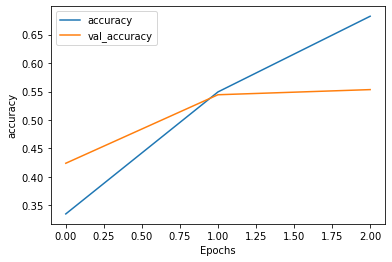

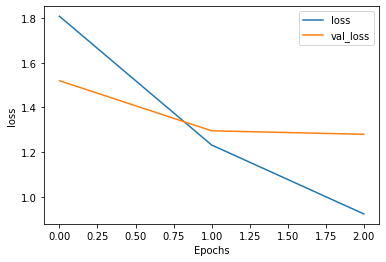

In [57]:
def plot_Text_fitting_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_Text_fitting_graph(history, 'accuracy')
plot_Text_fitting_graph(history, 'loss')

# observe validation accuracy plateaus around 55% 

In [58]:
model_predict_proba=model_seq_Text.predict(X_test_Text_preprocessed_sequences_padded)

In [59]:
# evaluate multi-class log-loss, JUST for predictions based on the 'Text' feature
model_multiclass_log_loss=log_loss((y_test_array+1),model_predict_proba,labels=[1,2,3,4,5,6,7,8,9]) #correcting the class labels
print('MultinomialNB multiclass_log_loss:',round(model_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.279941


#### Notes: * Thus we achieve a reasonable performance against a log-loss metric using the 'Text'. * Before inserting the 'Gene', 'Variation' features into the model, will create an equivalent Functional API

In [60]:
# FUNCTIONAL API ('Text')

In [61]:
input_B = tf.keras.layers.Input(shape=(max_length_seq,), name='Text_input')

# embedding layer expecting input vocab of size 10000, and output embedding dimension of size 128
hidden_1 = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_B)

# bidirectional wrapper on a single LSTM RNN layer, to run essentially run two layers on same inputs, one reading tokens
# left-to-right and the other right-to-left. then simply combine (concatenate) their outputs at each time step.
hidden_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=embedding_dim,return_sequences=False),merge_mode='concat')(hidden_1)

hidden_3 = tf.keras.layers.Dense(units=embedding_dim, activation='relu')(hidden_2)
hidden_4 = tf.keras.layers.Dropout(0.4)(hidden_3)

# NO CONCAT LAYER YET

# final dense layer with softmax activation to predict probability of each class
output = tf.keras.layers.Dense(units=9, activation='softmax')(hidden_4)

model_func_Text = tf.keras.Model(inputs=[input_B],outputs=[output])

model_func_Text.summary()

# observe the Bidirectional wrappers Output Shape as (None, embedding_dim*2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text_input (InputLayer)      [(None, 400)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 128)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 1,577,225
Trainable params: 1,577,225
Non-trainable params: 0
___________________________________________________

In [62]:
# reshape labels to expected into one-column arrays
y_train_array=np.reshape(np.array(y_train),(len(y_train),1))
y_test_array=np.reshape(np.array(y_test),(len(y_test),1))

print(y_train_array.shape)
print(y_test_array.shape)

(2656, 1)
(665, 1)


In [63]:
# the Dense 9-unit 'softmax' layer will compare against [0:8]
# thus need to re-assign (subtract 1) the nine label integers accordingly
y_train_array=y_train_array-1
y_test_array=y_test_array-1

In [64]:
model_func_Text.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#epochs = 10
epochs = 3
history = model_func_Text.fit(X_train_Text_preprocessed_sequences_padded,y_train_array,epochs=epochs,verbose=2,validation_data=(X_test_Text_preprocessed_sequences_padded,y_test_array))

Train on 2656 samples, validate on 665 samples
Epoch 1/3
2656/2656 - 7s - loss: 1.7955 - accuracy: 0.3460 - val_loss: 1.4573 - val_accuracy: 0.4632
Epoch 2/3
2656/2656 - 5s - loss: 1.2144 - accuracy: 0.5580 - val_loss: 1.3237 - val_accuracy: 0.5444
Epoch 3/3
2656/2656 - 5s - loss: 0.9003 - accuracy: 0.6871 - val_loss: 1.3421 - val_accuracy: 0.5398


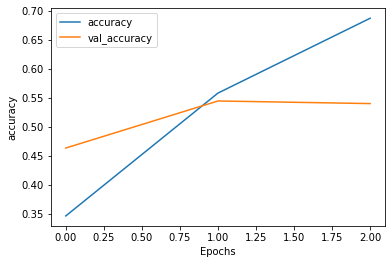

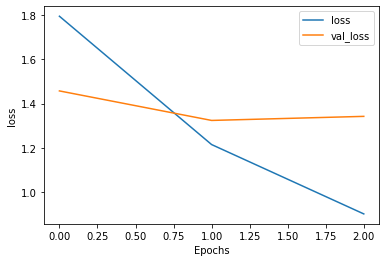

In [65]:
def plot_Text_fitting_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_Text_fitting_graph(history, 'accuracy')
plot_Text_fitting_graph(history, 'loss')

# observe validation accuracy plateaus around 55% 

In [66]:
model_predict_proba=model_func_Text.predict(X_test_Text_preprocessed_sequences_padded)

In [67]:
# evaluate multi-class log-loss, JUST for predictions based on the 'Text' feature
model_multiclass_log_loss=log_loss((y_test_array+1),model_predict_proba,labels=[1,2,3,4,5,6,7,8,9]) #correcting the class labels
print('MultinomialNB multiclass_log_loss:',round(model_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.342063


#### Process the 'Gene' and 'Variation' features

In [68]:
# one-hot encode 'Gene', 'Variation' - will keep ALL one-hot columns

cat_features=['Gene','Variation']

onehotenc=OneHotEncoder(drop=None,sparse=False,handle_unknown='ignore')

onehotenc.fit(X_train_df[cat_features].values.reshape(-1,len(cat_features)))

train_1hot_cols=onehotenc.transform(X_train_df[cat_features].values.reshape(-1,len(cat_features)))
test_1hot_cols=onehotenc.transform(X_test_df[cat_features].values.reshape(-1,len(cat_features)))

print('train_1hot_cols is of type: ', type(train_1hot_cols))
print('train_1hot_cols is of shape: ', train_1hot_cols.shape)
print('test_1hot_cols is of type: ', type(test_1hot_cols))
print('test_1hot_cols is of shape: ', test_1hot_cols.shape)

train_1hot_cols is of type:  <class 'numpy.ndarray'>
train_1hot_cols is of shape:  (2656, 2644)
test_1hot_cols is of type:  <class 'numpy.ndarray'>
test_1hot_cols is of shape:  (665, 2644)


In [69]:
# create dataframes with only the one-hot columns
X_train_1hot_cols_df=pd.DataFrame(train_1hot_cols.astype(int))
X_test_1hot_cols_df=pd.DataFrame(test_1hot_cols.astype(int))

print('X_train_1hot_cols_df is of type: ', type(X_train_1hot_cols_df))
print('X_train_1hot_cols_df is of shape: ', X_train_1hot_cols_df.shape)
print('X_test_1hot_cols_df is of type: ', type(X_test_1hot_cols_df))
print('X_test_1hot_cols_df is of shape: ', X_test_1hot_cols_df.shape)

X_train_1hot_cols_df is of type:  <class 'pandas.core.frame.DataFrame'>
X_train_1hot_cols_df is of shape:  (2656, 2644)
X_test_1hot_cols_df is of type:  <class 'pandas.core.frame.DataFrame'>
X_test_1hot_cols_df is of shape:  (665, 2644)


In [70]:
#rename dataframes' one-hot columns
X_train_1hot_cols_df.columns=onehotenc.get_feature_names()
X_test_1hot_cols_df.columns=onehotenc.get_feature_names()

In [71]:
print(y_train)
X_train_1hot_cols_df

0       4
1       4
2       4
3       7
4       4
       ..
2651    7
2652    2
2653    1
2654    4
2655    4
Name: Class, Length: 2656, dtype: int64


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,x1_y87c,x1_y87n,x1_y901c,x1_y931c,x1_y98h,x1_y98n,x1_yap1 fam118b fusion,x1_yap1 mamld1 fusion,x1_zc3h7b bcor fusion,x1_znf198 fgfr1 fusion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
print(y_test)
X_test_1hot_cols_df

0      2
1      6
2      7
3      7
4      7
      ..
660    1
661    7
662    4
663    7
664    1
Name: Class, Length: 665, dtype: int64


,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,x1_y87c,x1_y87n,x1_y901c,x1_y931c,x1_y98h,x1_y98n,x1_yap1 fam118b fusion,x1_yap1 mamld1 fusion,x1_zc3h7b bcor fusion,x1_znf198 fgfr1 fusion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# FUNCTIONAL API ('Gene'&'Variation')

In [74]:
input_A = tf.keras.layers.Input(shape=(X_train_1hot_cols_df.shape[1],), name='Gene_Variation_input')
hidden_1 = tf.keras.layers.Dense(units=128, activation='relu')(input_A)
hidden_2 = tf.keras.layers.Dropout(0.4)(hidden_1)
# NO CONCAT LAYER YET
# final dense layer with softmax activation to predict probability of each class
output = tf.keras.layers.Dense(units=9, activation='softmax')(hidden_2)
model_func_Gene_Variation = tf.keras.Model(inputs=[input_A],outputs=[output])

model_func_Gene_Variation.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gene_Variation_input (InputL [(None, 2644)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               338560    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 1161      
Total params: 339,721
Trainable params: 339,721
Non-trainable params: 0
_________________________________________________________________


In [75]:
# reshape labels to expected into one-column arrays
y_train_array=np.reshape(np.array(y_train),(len(y_train),1))
y_test_array=np.reshape(np.array(y_test),(len(y_test),1))

print(y_train_array.shape)
print(y_test_array.shape)

(2656, 1)
(665, 1)


In [76]:
# the Dense 9-unit 'softmax' layer will compare against [0:8]
# thus need to re-assign (subtract 1) the nine label integers accordingly
y_train_array=y_train_array-1
y_test_array=y_test_array-1

In [77]:
model_func_Gene_Variation.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

epochs = 10
history = model_func_Gene_Variation.fit(X_train_1hot_cols_df,y_train_array,epochs=epochs,verbose=2,validation_data=(X_test_1hot_cols_df,y_test_array))

Train on 2656 samples, validate on 665 samples
Epoch 1/10
2656/2656 - 0s - loss: 2.0338 - accuracy: 0.3313 - val_loss: 1.8196 - val_accuracy: 0.3429
Epoch 2/10
2656/2656 - 0s - loss: 1.6046 - accuracy: 0.4797 - val_loss: 1.5042 - val_accuracy: 0.5098
Epoch 3/10
2656/2656 - 0s - loss: 1.2539 - accuracy: 0.6141 - val_loss: 1.3065 - val_accuracy: 0.5684
Epoch 4/10
2656/2656 - 0s - loss: 1.0045 - accuracy: 0.6947 - val_loss: 1.2215 - val_accuracy: 0.5789
Epoch 5/10
2656/2656 - 0s - loss: 0.8218 - accuracy: 0.7538 - val_loss: 1.1841 - val_accuracy: 0.5865
Epoch 6/10
2656/2656 - 0s - loss: 0.6792 - accuracy: 0.8042 - val_loss: 1.1677 - val_accuracy: 0.5624
Epoch 7/10
2656/2656 - 0s - loss: 0.5476 - accuracy: 0.8566 - val_loss: 1.1561 - val_accuracy: 0.5835
Epoch 8/10
2656/2656 - 0s - loss: 0.4356 - accuracy: 0.9074 - val_loss: 1.1517 - val_accuracy: 0.5744
Epoch 9/10
2656/2656 - 0s - loss: 0.3400 - accuracy: 0.9375 - val_loss: 1.1562 - val_accuracy: 0.5639
Epoch 10/10
2656/2656 - 0s - loss: 

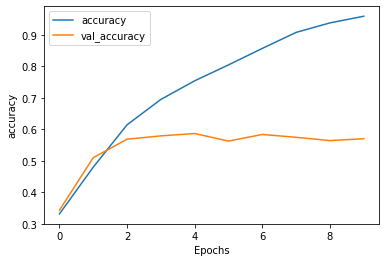

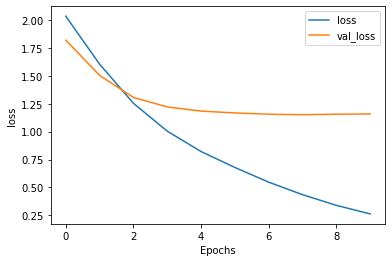

In [78]:
def plot_Text_fitting_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_Text_fitting_graph(history, 'accuracy')
plot_Text_fitting_graph(history, 'loss')

# observe validation accuracy plateaus around 56%

In [79]:
model_predict_proba=model_func_Gene_Variation.predict(X_test_1hot_cols_df)

In [80]:
# evaluate multi-class log-loss, JUST for predictions based on the 'Gene' & 'Variation' features
model_multiclass_log_loss=log_loss((y_test_array+1),model_predict_proba,labels=[1,2,3,4,5,6,7,8,9]) #correcting the class labels
print('MultinomialNB multiclass_log_loss:',round(model_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.158741


In [81]:
# FUNCTIONAL API ('Text' combined with 'Gene'&'Variation')

In [82]:
input_A = tf.keras.layers.Input(shape=(X_train_1hot_cols_df.shape[1],), name='Gene_Variation_input')
hidden_1A = tf.keras.layers.Dense(units=128, activation='relu')(input_A)
hidden_2A = tf.keras.layers.Dropout(0.4)(hidden_1A)

input_B = tf.keras.layers.Input(shape=(max_length_seq,), name='Text_input')

# embedding layer expecting input vocab of size 10000, and output embedding dimension of size 128
hidden_1B = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_B)

# bidirectional wrapper on a single LSTM RNN layer, to run essentially run two layers on same inputs, one reading tokens
# left-to-right and the other right-to-left. then simply combine (concatenate) their outputs at each time step.
hidden_2B = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=embedding_dim,return_sequences=False),merge_mode='concat')(hidden_1B)

hidden_3B = tf.keras.layers.Dense(units=embedding_dim, activation='relu')(hidden_2B)
hidden_4B = tf.keras.layers.Dropout(0.4)(hidden_3B)

concat = tf.keras.layers.concatenate([hidden_2A,hidden_4B])

hidden_5 = tf.keras.layers.Dense(units=64, activation='relu')(concat)
hidden_6 = tf.keras.layers.Dropout(0.4)(hidden_5)

# final dense layer with softmax activation to predict probability of each class
output = tf.keras.layers.Dense(units=9, activation='softmax')(hidden_6)

model_func_all = tf.keras.Model(inputs=[input_A,input_B],outputs=[output])

model_func_all.summary()

# observe the Bidirectional wrappers Output Shape as (None, embedding_dim*2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 128)     1280000     Text_input[0][0]                 
__________________________________________________________________________________________________
Gene_Variation_input (InputLaye [(None, 2644)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          263168      embedding_2[0][0]                
____________________________________________________________________________________________

In [83]:
# reshape labels to expected into one-column arrays
y_train_array=np.reshape(np.array(y_train),(len(y_train),1))
y_test_array=np.reshape(np.array(y_test),(len(y_test),1))

print(y_train_array.shape)
print(y_test_array.shape)

(2656, 1)
(665, 1)


In [84]:
# the Dense 9-unit 'softmax' layer will compare against [0:8]
# thus need to re-assign (subtract 1) the nine label integers accordingly
y_train_array=y_train_array-1
y_test_array=y_test_array-1

In [85]:
X_train_A = X_train_1hot_cols_df
X_train_B = X_train_Text_preprocessed_sequences_padded

X_test_A = X_test_1hot_cols_df
X_test_B = X_test_Text_preprocessed_sequences_padded

In [86]:
model_func_all.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#epochs = 10
epochs = 3
history = model_func_all.fit((X_train_A,X_train_B),y_train_array,epochs=epochs,verbose=2,validation_data=((X_test_A,X_test_B),y_test_array))

Train on 2656 samples, validate on 665 samples
Epoch 1/3
2656/2656 - 7s - loss: 1.8602 - accuracy: 0.2978 - val_loss: 1.4745 - val_accuracy: 0.4677
Epoch 2/3
2656/2656 - 5s - loss: 1.3398 - accuracy: 0.5264 - val_loss: 1.2649 - val_accuracy: 0.5383
Epoch 3/3
2656/2656 - 5s - loss: 0.9829 - accuracy: 0.6619 - val_loss: 1.1830 - val_accuracy: 0.5850


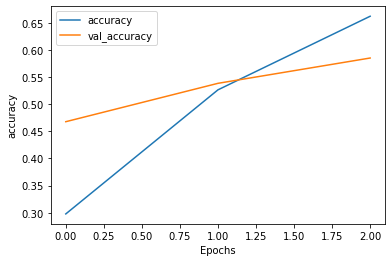

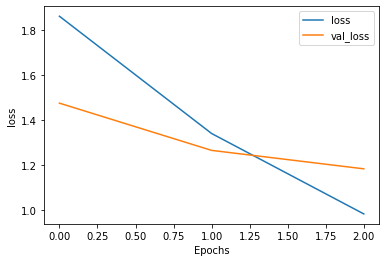

In [87]:
def plot_Text_fitting_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_Text_fitting_graph(history, 'accuracy')
plot_Text_fitting_graph(history, 'loss')

# observe validation accuracy plateaus around 57%

In [88]:
model_predict_proba=model_func_all.predict((X_test_A,X_test_B))

In [89]:
# evaluate multi-class log-loss
model_multiclass_log_loss=log_loss((y_test_array+1),model_predict_proba,labels=[1,2,3,4,5,6,7,8,9]) #correcting the class labels
print('MultinomialNB multiclass_log_loss:',round(model_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.182961


In [90]:
#saving the full Functional API-based model

model_func_all.save("Kaggle_Personalized_Medicine_Redefining_Cancer_Treatment_using_RNNs_TensorFlow_2p1.h5")

In [91]:
#LOAD MODEL HERE

model_final=tf.keras.models.load_model("Kaggle_Personalized_Medicine_Redefining_Cancer_Treatment_using_RNNs_TensorFlow_2p1.h5")
model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_input (InputLayer)         [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 128)     1280000     Text_input[0][0]                 
__________________________________________________________________________________________________
Gene_Variation_input (InputLaye [(None, 2644)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 256)          263168      embedding_2[0][0]                
____________________________________________________________________________________________

In [92]:
model_final_predict_proba=model_final.predict((X_test_A,X_test_B))

In [93]:
# evaluate multi-class log-loss, ON TEST SET
model_multiclass_log_loss=log_loss((y_test_array+1),model_final_predict_proba,labels=[1,2,3,4,5,6,7,8,9]) #correcting the class labels
print('MultinomialNB multiclass_log_loss:',round(model_multiclass_log_loss,6))

MultinomialNB multiclass_log_loss: 1.182961


In [94]:
# Generate class target names for report table
target_names = ['class1','class2','class3','class4','class5','class6','class7','class8','class9']

In [95]:
# Evaluate predictions, ON TEST SET
y_pred=(np.argmax(model_final_predict_proba,axis=1))+1

print('Classification report (test set):\n')
print(classification_report((y_test_array+1),y_pred,target_names=target_names)) #correcting the class labels

Classification report (test set):

              precision    recall  f1-score   support

      class1       0.52      0.65      0.58       114
      class2       0.52      0.44      0.48        91
      class3       0.00      0.00      0.00        18
      class4       0.72      0.58      0.65       137
      class5       0.26      0.35      0.30        48
      class6       0.71      0.53      0.60        55
      class7       0.65      0.78      0.71       191
      class8       0.00      0.00      0.00         4
      class9       0.00      0.00      0.00         7

    accuracy                           0.58       665
   macro avg       0.38      0.37      0.37       665
weighted avg       0.57      0.58      0.57       665



C:\Users\dcunz\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix (test set):


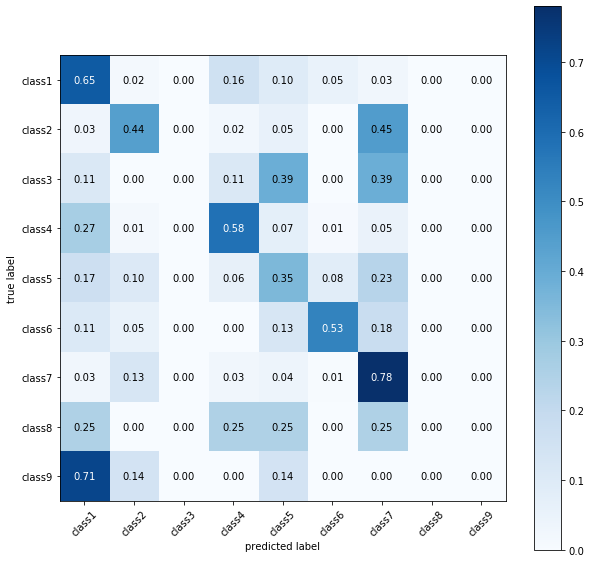

In [96]:
print('Confusion matrix (test set):')
cm=confusion_matrix((y_test_array+1),y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize=(10, 10),
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                class_names=target_names,
                               )
plt.show()

#### Comments: Classes 2,3,5 show significantly lower recall rates than the other classes; and all scores are significantly lower than train set, indicating that this model DOES NOT GENERALIZE well, and overfits the train set.

### Load competition data

In [97]:
# read in full test data
test_variants=pd.read_csv('stage2_test_variants.csv')
test_text=pd.read_csv('stage2_test_text.csv',sep='\|\|',engine='python',skiprows=1,names=['ID','Text'])

# merge both test dataframes
testing_full=test_variants.merge(test_text, on='ID', how='inner')

#remove leading and trailing spaces and lower-case 'Gene' and 'Variation' features
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.strip())
testing_full['Gene']=testing_full['Gene'].apply(lambda x: x.lower())
testing_full['Variation']=testing_full['Variation'].apply(lambda x: x.strip())
testing_full['Variation']=testing_full['Variation'].apply(lambda x: x.lower())

#review missing values for 'Text'
indices_of_missing_Text=testing_full[testing_full['Text'].isnull()==True].index
testing_full.iloc[indices_of_missing_Text]

#impute missing value for 'Text', by combining its corresponding 'Gene', 'Variation' features (separated by one white space)
testing_full.Text.fillna((testing_full.Gene+' '+testing_full.Variation),inplace=True)
testing_full.iloc[indices_of_missing_Text]

,ID,Gene,Variation,Text


In [98]:
# clean up text data on BOTH 'Variation' and 'Text' features, prior to applying the tensorflow Tokenizer
testing_full['Variation'] = testing_full['Variation'].apply(text_preprocessor_tokenizer)
testing_full['Text'] = testing_full['Text'].apply(text_preprocessor_tokenizer)

In [99]:
testing_full

,ID,Gene,Variation,Text
0,1,chek2,h371y,the incidence of breast cancer is increasing i...
1,2,axin2,truncating mutations,an unselected series of 310 colorectal carcino...
2,3,wnt4,e216g,mycosis fungoides and sã zary syndrome are pri...
3,4,sucla2,g118r,regulated progression through the cell cycle r...
4,5,braf,t599instt,pilocytic astrocytoma pa is emerging as a tumo...
...,...,...,...,...
981,982,tp63,s580p,iîºb kinase î² ikkî² is involved in tumor deve...
982,983,scn4a,r672g,he identification of subtype specific transloc...
983,984,braf,n581h,cardio facio cutaneous cfc syndrome mim 115150...
984,985,tshr,s281n,screening for tumor suppressor genes in breast...


In [100]:
# pre-process 'Text'

STOPWORDS = set(stopwords.words('english'))
print(len(STOPWORDS))

dummy=[]
testing_full_Text_list=[]

for i in range(len(testing_full)):
    for word in testing_full.Text[i].split():
        if word not in list(STOPWORDS):
            dummy.append(word)
    testing_full_Text_list.append(dummy)
    dummy=[]

testing_full_Text_str=[]
for i in range(len(testing_full)):
    testing_full_Text_str.append(' '.join(testing_full_Text_list[i]))

print(len(testing_full_Text_str))
print(type(testing_full_Text_str))
print(type(testing_full_Text_str[0]))

# now each testing_full_Text_str[x] contains a single string, representing each of the studies, with all STOPWORDS removed
testing_full_Text_str[985]

179
986
<class 'list'>
<class 'str'>


'histiocytic neoplasms clonal hematopoietic disorders characterized accumulation abnormal monocyte derived dendritic cells macrophages langerhans cell lch non langerhans non lch histiocytoses respectively discovery brafv600e mutations 50 patients provided first molecular therapeutisc target histiocytosis however recurrent driving mutations majority brafv600e wildtype non lch patients unknown recurrent cooperating mutations non map kinase pathways undefined histiocytic neoplasms test proteins transplants neuroblastoma mutations reduction monoallelic histological residues 273 arch mdm2amp addition map kinase pathway lesions recurrently altered genes involving diverse cellular pathways identified treatment map2k1 araf mutated non lch patients using mek raf inhibitors respectively resulted clinical efficacy demonstrating importance detecting targeting diverse kinase alterations disorders go introduction systemic histiocytic neoplasms consist langerhans cell histiocytosis lch non langerhans

In [101]:
# Re-create full TESTING dataframe by replacing 'Text' with the newly-processed text strings as above:

Text_preprocessed=pd.DataFrame(testing_full_Text_str,columns=['Text_preprocessed'])
testing_full_df=pd.concat([testing_full,Text_preprocessed],axis=1).drop(columns=['Text'])

testing_full_df

,ID,Gene,Variation,Text_preprocessed
0,1,chek2,h371y,incidence breast cancer increasing china recen...
1,2,axin2,truncating mutations,unselected series 310 colorectal carcinomas st...
2,3,wnt4,e216g,mycosis fungoides sã zary syndrome primary cut...
3,4,sucla2,g118r,regulated progression cell cycle requires sequ...
4,5,braf,t599instt,pilocytic astrocytoma pa emerging tumor entity...
...,...,...,...,...
981,982,tp63,s580p,iîºb kinase î² ikkî² involved tumor developmen...
982,983,scn4a,r672g,identification subtype specific translocations...
983,984,braf,n581h,cardio facio cutaneous cfc syndrome mim 115150...
984,985,tshr,s281n,screening tumor suppressor genes breast cancer...


In [102]:
# Tokenize 'Text_preprocessed'

testing_full_Text_preprocessed_sequences = tokenizer.texts_to_sequences(testing_full_df.Text_preprocessed)

testing_full_Text_preprocessed_sequences_padded=pad_sequences(testing_full_Text_preprocessed_sequences,maxlen=max_length_seq,padding=padding_type,truncating=trunc_type)

print(len(testing_full_Text_preprocessed_sequences[0]))
print(len(testing_full_Text_preprocessed_sequences_padded[0]))
print(testing_full_Text_preprocessed_sequences_padded[0])

3861
400
[1208  139   14 1069 5741  475 4943 1114  139   14 3517  246   43  212
   21 4531 1881  346    2  139   14 1704   61   37    1 9898  310    1
    1 1077  641   43 4531  139   14  421    1    1  755  139   14 1704
   61  296 4531  139   14  421  200 1762   59 2278    6  366 3037   25
    5   28  148 3041    1    1  400    1    7  380  520    1 1476    1
   25 1259  210  152    6  366  388  407   36  472    1    8    9  778
 2278   32  645   75  428   68  149 5341 7109 1434   26   77 4339 2136
 8236   57   26   77    1 7980 1175 1478   25   26   77    1    1    1
    8    9  778 2278  225 7426 8446  181 1574    1    1   15  129   36
  885   80    1 5341 7109 1434   26 2278  179 4126 1381 7444 1004   42
 1357  610 1374 2278   77    1    1   42  187   25   26    1    8    9
  778  339   66  371 2278 2054  139   14 1704   32    1    1    8    9
  755  652   10   11 6867 5146   25   58 2278 2441 6118  126  139   14
  334 3142 1881    1    1    8    9  755    1    8    9  664  346   

In [103]:
print(testing_full_df.Text_preprocessed[0])

incidence breast cancer increasing china recent decades familial breast cancer accounts 5â 10 total patients chinese women germline mutations breast cancer susceptibility genes brca1 mimâ 113705 brca2 mimâ 600185 responsible approximately 10 chinese breast cancer families liede narod 2002 breast cancer susceptibility genes related chinese breast cancer families therefore remain identified chek2 cell cycle checkpoint kinase 2 also known chk2 mimâ 604373 nm 007194 3 located chromosome 22q encodes multifunctional kinase plays important role cell cycle regulation apoptosis dna repair bartek et al 2001 chek2 gene contains three distinct functional domains sq tq rich domain residues 19â 69 forkhead associated domain residues 115â 165 serine threonine kinase domain residues 225â 490 bartek et al 2001 chek2 activated ataxia telangiectasia mutated atm mimâ 607585 protein response dna damage phosphorylation t68 sq tq rich domain chek2 likely initiating event prerequisite subsequent activation st

In [104]:
print(decode_text(testing_full_Text_preprocessed_sequences_padded[0]))

incidence breast cancer increasing china recent decades familial breast cancer accounts 5â 10 total patients chinese women germline mutations breast cancer susceptibility genes brca1 <OOV> 113705 brca2 <OOV> <OOV> responsible approximately 10 chinese breast cancer families <OOV> <OOV> 2002 breast cancer susceptibility genes related chinese breast cancer families therefore remain identified chek2 cell cycle checkpoint kinase 2 also known chk2 <OOV> <OOV> nm <OOV> 3 located chromosome <OOV> encodes <OOV> kinase plays important role cell cycle regulation apoptosis dna repair <OOV> et al 2001 chek2 gene contains three distinct functional domains sq tq rich domain residues 19â 69 forkhead associated domain residues <OOV> 165 serine threonine kinase domain residues <OOV> <OOV> <OOV> et al 2001 chek2 activated ataxia telangiectasia mutated atm <OOV> <OOV> protein response dna damage phosphorylation <OOV> sq tq rich domain chek2 likely initiating event prerequisite subsequent activation step f

In [105]:
# Process the 'Gene' and 'Variation' features

cat_features=['Gene','Variation']

testing_1hot_cols=onehotenc.transform(testing_full_df[cat_features].values.reshape(-1,len(cat_features)))

print('testing_1hot_cols is of type: ', type(testing_1hot_cols))
print('testing_1hot_cols is of shape: ', testing_1hot_cols.shape)

testing_1hot_cols is of type:  <class 'numpy.ndarray'>
testing_1hot_cols is of shape:  (986, 2644)


In [106]:
testing_1hot_cols_df=pd.DataFrame(testing_1hot_cols.astype(int))

print('X_test_1hot_cols_df is of type: ', type(testing_1hot_cols_df))
print('X_test_1hot_cols_df is of shape: ', testing_1hot_cols_df.shape)

X_test_1hot_cols_df is of type:  <class 'pandas.core.frame.DataFrame'>
X_test_1hot_cols_df is of shape:  (986, 2644)


In [107]:
testing_1hot_cols_df.columns=onehotenc.get_feature_names()

In [108]:
testing_1hot_cols_df

,x0_abl1,x0_acvr1,x0_ago2,x0_akt1,x0_akt2,x0_akt3,x0_alk,x0_apc,x0_ar,x0_araf,...,x1_y87c,x1_y87n,x1_y901c,x1_y931c,x1_y98h,x1_y98n,x1_yap1 fam118b fusion,x1_yap1 mamld1 fusion,x1_zc3h7b bcor fusion,x1_znf198 fgfr1 fusion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Evaluate competition test data

In [109]:
X_testing_A = testing_1hot_cols_df
X_testing_B = testing_full_Text_preprocessed_sequences_padded

In [110]:
model_final_predict_proba=model_final.predict((X_testing_A,X_testing_B))

In [111]:
# Create CSV file for competition entry
model_final_predict_proba_for_competition=pd.DataFrame(model_final_predict_proba)
model_final_predict_proba_for_competition=pd.concat([sample_submission[['ID']],model_final_predict_proba_for_competition],axis=1)
model_final_predict_proba_for_competition.columns=sample_submission.columns

### DataFrame for submission: Probabilistic prediction, into 9 classes, of genetic variations in test files (stage2_test_variants & stage2_test_text)

In [112]:
model_final_predict_proba_for_competition

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.326537,0.038403,0.022052,0.473053,0.045060,0.053244,0.031555,0.004353,0.005744
1,2,0.830317,0.009750,0.005673,0.115603,0.010436,0.015109,0.010064,0.000983,0.002065
2,3,0.116739,0.258705,0.019729,0.216271,0.041780,0.027431,0.308385,0.004016,0.006945
3,4,0.201997,0.113907,0.061504,0.141410,0.167570,0.119188,0.109792,0.031968,0.052664
4,5,0.004607,0.346123,0.002415,0.010146,0.009413,0.003050,0.623089,0.000175,0.000982
...,...,...,...,...,...,...,...,...,...,...
981,982,0.038603,0.213291,0.020521,0.061981,0.041324,0.018631,0.594436,0.003325,0.007887
982,983,0.094497,0.258599,0.049604,0.108232,0.115766,0.067878,0.246650,0.021641,0.037133
983,984,0.011985,0.534787,0.007582,0.013223,0.027981,0.012918,0.383175,0.001335,0.007015
984,985,0.570137,0.012645,0.010478,0.249392,0.060555,0.079832,0.011072,0.001993,0.003896


In [113]:
model_final_predict_proba_for_competition.to_csv('DC20200212',index=False)

## Submission #3, by Daniel Cunza - Private Score: 3.04077, Public Score: 1.24905
#### Competition position (Private Leaderboard): 220th out of 355 participants

## Conclusions:

#### * Given the observed recall rates, classes 3 and 5 were observed as the most the significant culprits for the lower test-set classifications scores; and the errors for BOTH of these classes were mostly due to mis-classifications as class 7. Thus, IF this model were to be used, recommending precision/recall thresholds be adjusted for optimal recall among classes 3, 5, and 7.

#### * Final submitted files:
- Neural network model: Kaggle_Personalized_Medicine_Redefining_Cancer_Treatment_using_RNNs_TensorFlow_2p1.h5 
- CSV probability prediction: DC20200212.csv

#### * TODO:  
1. Create pipelines for all data pre-processing, for better code portability.
2. Attempt another classification strategy; specifically, Support Vector Machines (SVMs) would be a good candidate. 